In [116]:
import math
import time
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers.core import Activation, Dense, Dropout
from keras.layers.recurrent import LSTM

## Data Pre-processing

The data from the csv is of an NxD matrix where N represents the number of examples and D is the number of features. This data will need to be normalized and split into windows of size 30 (represents the number of consecutive days) which results in a tensor. The dimensions are then N-w x d x D, where N is the number of examples, w is the window size, d is the number of days to examine in each sampled data, and D is the number of features.

The normalization process is as follows for every feature. For each window, dividing each value by the first value in the window and then, subtract 1. 

After normalizing, the data is split into 90% training data and 10% test data. This is done such that 90% of the windows are used for training data and 10% of the windows are used for testing. We shuffle the windows but not the contents within the window, which ensures that the order of the consecutive days is maintained within the window. 

In [117]:
window_size = 30
file_name = "blockchain_data.csv"
dropout = 0.2
activation_function="linear"
loss_function="mse"
optimizer="adam"
batch_size=1024
nb_epoch=50
validation_split=0.05

raw_dataset = pd.read_csv(file_name)
print("Shape of Data with date: ", raw_dataset.shape)

# Remove date column and change data types to float
dataset = raw_dataset.drop('Date', 1)
print("Shape of data without date: ", dataset.shape)

Shape of Data with date:  (1818, 11)
Shape of data without date:  (1818, 10)


In [118]:
dataset = dataset.values.tolist()
tmp_arr = []
for idx in range(len(dataset) - window_size):
    tmp_arr.append(dataset[idx: idx + window_size])

data = np.array(tmp_arr)
data.shape

(1788, 30, 10)

In [119]:
# Normalize the data
normalized_data = np.zeros_like(data)
normalized_data[:,1:,:] = data[:,1:,:] / data[:, 0:1, :] - 1
print(normalized_data.shape)
normalized_data[-1,:,:]

(1788, 30, 10)


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 5.03526891e-03,  0.00000000e+00, -5.37740978e-02,
         4.42871620e-02,  4.05405405e-02,  1.19726116e-01,
        -1.03708813e-01, -1.34670718e-01, -6.73726840e-02,
        -8.07617418e-02],
       [-9.86339474e-03,  0.00000000e+00, -1.30137313e-01,
        -6.01418068e-02, -5.40540541e-02, -1.25549454e-01,
         1.36215627e-01,  4.38104636e-02,  7.47985663e-02,
         2.13392749e-01],
       [-4.10274140e-02,  0.00000000e+00, -2.36333955e-02,
        -4.15726959e-02, -6.75675676e-03, -1.70761313e-01,
         1.63654365e-01,  1.50475409e-01,  1.55791835e-01,
         4.98619751e-01],
       [-4.33078568e-02,  0.00000000e+00, -1.24267390e-01,
        -7.93547396e-02, -4.05405405e-02, -1.87216289e-01,
         1.80567168e-01,  8.13382457e-02,  1.32706337e-01,
         1.

In [120]:
# Split the data
split_idx = round(0.9*normalized_data.shape[0])
training_data = normalized_data[:int(split_idx), :]
np.random.shuffle(training_data)

X_train = training_data[:, :-1]
Y_train = training_data[:, -1]
Y_train = Y_train[:, 0]
print(X_train.shape)
print(Y_train.shape)

X_test = normalized_data[int(split_idx):, :-1]
Y_test = normalized_data[int(split_idx):, -1, :]
Y_test = Y_test[:, 0]
print(X_test.shape)
print(Y_test.shape)

Y_daybefore = normalized_data[int(split_idx):, -2, :]
Y_daybefore = Y_daybefore[:, 0]
print(Y_daybefore.shape)

# this is because the last window is used as the target
sequence_length = window_size
window_size = window_size - 1

(1609, 29, 10)
(1609,)
(179, 29, 10)
(179,)
(179,)


## Training Step

In [121]:
# create the model
model = Sequential()

# First layer
model.add(Bidirectional(LSTM(window_size, return_sequences=True), input_shape=(window_size, X_train.shape[-1]),))
model.add(Dropout(dropout))

# Second layer
model.add(Bidirectional(LSTM(window_size*2, return_sequences=True)))
model.add(Dropout(dropout))

# Third layer
model.add(Bidirectional(LSTM(window_size, return_sequences=False)))

# Output Layer
model.add(Dense(units=1))
model.add(Activation(activation_function))

model.compile(loss=loss_function, optimizer=optimizer)

In [122]:
start = time.time()
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch, validation_split=validation_split)
training_time = int(math.floor(time.time() - start))
print("Training time", training_time, "seconds")

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1528 samples, validate on 81 samples
Epoch 1/50
1528/1528 [==============================] - 5s 4ms/step - loss: 0.0758 - val_loss: 0.0490
Epoch 2/50
1528/1528 [==============================] - 2s 1ms/step - loss: 0.0376 - val_loss: 0.0356
Epoch 3/50
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0282 - val_loss: 0.0271
Epoch 4/50
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0214 - val_loss: 0.0224
Epoch 5/50
1528/1528 [==============================] - 2s 1ms/step - loss: 0.0186 - val_loss: 0.0216
Epoch 6/50
1528/1528 [==============================] - 2s 1ms/step - loss: 0.0178 - val_loss: 0.0186
Epoch 7/50
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0145 - val_loss: 0.0164
Epoch 8/50
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0123 - val_loss: 0.0156
Epoch 9/50
1528/1528 [==============================] - 2s 2ms/step - loss: 0.0118 - val_loss: 0.0146
Epoch 10/50
1528/1528 [=============

ValueError: Number of samples, -179, must be non-negative.

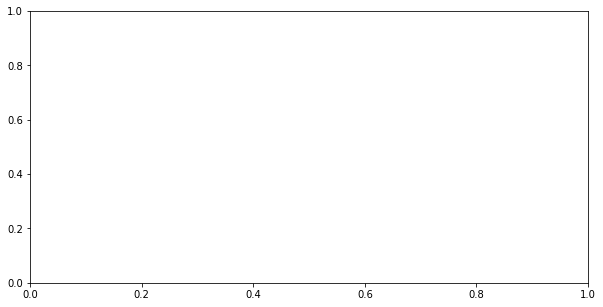

In [146]:
#Test the model
y_predict = model.predict(X_test)

#Create empty 2D arrays to store unnormalized values
real_y_test = np.zeros_like(Y_test)
real_y_predict = np.zeros_like(y_predict)
unnormalized_bases = data[split_idx:,0:1,0]


#Fill the 2D arrays with the real value and the predicted value by reversing the normalization process
for i in range(Y_test.shape[0]):
    y = Y_test[i]
    predict = y_predict[i]
    real_y_test[i] = (y+1)*unnormalized_bases[i]
    real_y_predict[i] = (predict+1)*unnormalized_bases[i]
import matplotlib.dates as mdates

#Plot of the predicted prices versus the real prices
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
now = dt.datetime.now()
then = now - dt.timedelta(days=real_y_predict.shape[0])
days = mdates.drange(then,dt.timedelta(days=1))
ax.set_title("Bitcoin Price over last 6 months")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.plot(days, real_y_predict, color = 'green', label = 'Predicted Price')
plt.plot(days, real_y_test, color = 'red', label = 'Actual Price')
ax.set_ylabel("Price (USD)")
ax.set_xlabel("Time (Days)")
ax.legend()
